This notebook is being used to build the part of the cookbook that will perform the analyses. This will be merged in the future once all parts of the cookbook are complete. 

## Import packages

In [2]:
import pandas as pd
import numpy as np
import scipy.stats
from scipy.stats import pearsonr
import matplotlib.pyplot as plt
import re
import seaborn as sns
import statsmodels.stats.multitest
import sys
import urllib3
import json

import CPTAC.Endometrial as CPTAC

Welcome to the CPTAC data service package. Available datasets may be
viewed using CPTAC.list(). In order to access a specific data set,
import a CPTAC subfolder using either 'import CPTAC.Dataset' or 'from
CPTAC import Dataset'.
******
Version: 0.2.5
******
Loading Endometrial CPTAC data:
Loading Dictionary...
Loading Clinical Data...
Loading Acetylation Proteomics Data...
Loading Proteomics Data...
Loading Transcriptomics Data...
Loading CNA Data...
Loading Phosphoproteomics Data...
Loading Somatic Mutation Data...

 ******PLEASE READ******
CPTAC is a community resource project and data are made available
rapidly after generation for community research use. The embargo
allows exploring and utilizing the data, but the data may not be in a
publication until July 1, 2019. Please see
https://proteomics.cancer.gov/data-portal/about/data-use-agreement or
enter embargo() to open the webpage for more details.


## Edit desired variables

In [3]:
'''Mutated gene of interest'''
gene = 'PIK3CA'

'''Database of interest'''
database = 'Endometrial'

'''Select which dataframes you want to analyze '''
proteomics = True
phosphoproteomics = True
transcriptomics = True
sub_type = True

## Get the dataframes

In [4]:
somatic = CPTAC.get_somatic()
proteomics = CPTAC.get_proteomics()
phos = CPTAC.get_phosphoproteomics()

## General gene statistics

In [5]:
'''Get the hotspot3D output '''
hotspot_data = pd.ExcelFile('../HotSpot3D_Output/HotSpot3DOutput.xlsx')

'''Get the sheet name called Clusters to find the protein hotspot'''
clusters = hotspot_data.parse('Clusters')


try:
    '''Check if the gene of interest has a hotspot'''
    hotspot_areas = clusters.loc[clusters['Gene/Drug'] == gene]
    hotspot_mutations = hotspot_areas['Mutation/Gene']
    hotspot_mutations = hotspot_mutations.tolist()

    '''A list of mutations present in the hotspot according to our Hotspot3D output'''
    mutated_hotspot = somatic.loc[(somatic['Location'].isin(hotspot_mutations)) & (somatic['Gene'] == gene)]
    hotspot_patients = mutated_hotspot['Clinical_Patient_Key']
    print('Patients with hotspot mutations: \n')
    print(hotspot_patients)
    
    #Convert to a list for further statistical analysis
    hotspot_patients = hotspot_patients.tolist()
    
except:
    print('{}' '{}'.format(gene, ' does not have a hotspot in our data.'))
    hotspot = False

Patients with hotspot mutations: 

160      S001
1147     S003
1357     S009
4630     S021
16486    S023
19061    S024
21259    S032
21516    S033
22497    S038
37421    S061
38155    S063
39522    S066
43391    S067
43490    S068
46662    S084
47360    S088
47857    S090
49362    S097
49475    S098
Name: Clinical_Patient_Key, dtype: object


### Mutation Frequency

Total number of patients with PIK3CA mutations: 46
Total number of PIK3CA mutation instances: 62

                   Mutation Count
Missense_Mutation              58
In_Frame_Del                    3
Frame_Shift_Ins                 1


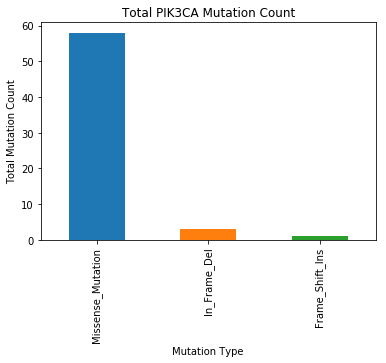

In [12]:
gene_mutated = somatic.loc[somatic['Gene'] == gene]
num_mutated = len(set(gene_mutated['Clinical_Patient_Key'])) - 1

'''This naturally includes a value that is 'NA' so we subtract 1'''
'''Some people have more than one mutation so we need to grab the unique values'''

print('{}' '{}' '{}' '{}' .format('Total number of patients with ' , gene, ' mutations: ', num_mutated))
total_mutations = len(gene_mutated)
print('{}' '{}' '{}' '{}' '{}'.format('Total number of ' , gene, ' mutation instances: ', total_mutations, '\n'))

'''Count the number of instances of various mutation types in the column 'Mutation' in the gene_mutated dataframe.'''

mut_counts = gene_mutated['Mutation'].value_counts()

'''The previous function returns a series. Convert the series to a dataframe'''
counts_df = mut_counts.to_frame()

'''Rename the column to clarify the number of mutations'''
counts_df = counts_df.rename(index=str, columns = { 'Mutation' : 'Mutation Count'})
print(counts_df)

'''Plot the frequencies'''
fig = mut_counts.plot.bar()

fig.set_title('{}' '{}' '{}'.format('Total ', gene, ' Mutation Count'))
fig.set_ylabel('Total Mutation Count')
fig.set_xlabel('Mutation Type')
plt.show()

### Hotspot Mutation Frequency

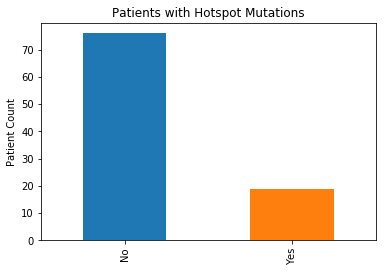

In [9]:
all_mutations = somatic['Clinical_Patient_Key']

all_patients = []

# Get all the unique paitients in the mutation list 
for name in all_mutations:
    if name not in all_patients:
        all_patients.append(name)

hotspot_indices = []      
for i in range(0, len(all_patients)):
    if all_patients[i] in hotspot_patients:
        hotspot_indices.append(i)

patients_df = pd.DataFrame()
patients_df['Patient_ID'] = all_patients
patients_df['Hotspot Mutation'] = 'No'
patients_df.loc[hotspot_indices, 'Hotspot Mutation'] = 'Yes'

patient_counts = patients_df['Hotspot Mutation'].value_counts()
fig = patient_counts.plot.bar()
fig.set_title('Patients with Hotspot Mutations')
fig.set_ylabel('Patient Count')
plt.show()